# **Time Travel:**

Time Travel in LangGraph enhances human-in-the-loop capabilities by allowing us to browse history, replay past states, and fork from previous states. This feature is valuable for debugging, approval workflows, or reusing prior states with new inputs.

### **Set up Everything:**

In [13]:
%%capture --no-stderr
%pip install -qU langgraph langchain-google-genai langchain_core langchain_community

In [14]:
# For Colab, use this:
from google.colab import userdata
GEMINI_API_KEY = userdata.get("GEMINI_API_KEY")

In [15]:
from langchain_google_genai import ChatGoogleGenerativeAI

gemini_flash: ChatGoogleGenerativeAI = ChatGoogleGenerativeAI(
    model='gemini-1.5-flash',
    temperature=0,
    api_key=GEMINI_API_KEY
)

In [16]:
def multiply(a: int, b: int) -> int:
    """Multiply two numbers."""
    return a * b

def add(a: int, b: int) -> int:
    """Add two numbers."""
    return a + b

def subtract(a: int, b: int) -> int:
    """Subtract two numbers."""
    return a - b

def divide(a: int, b: int) -> float:
    """Divide two numbers."""
    return a / b

tools = [add, subtract, multiply, divide]

In [17]:
llm_with_tools = gemini_flash.bind_tools(tools)

In [18]:
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage

sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

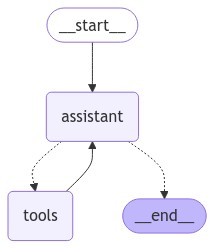

In [19]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display
from langgraph.checkpoint.memory import MemorySaver

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine the control flow
builder.add_edge(START, "assistant")
builder.add_conditional_edges("assistant",tools_condition)
# If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
# If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
builder.add_edge("tools", "assistant")

memory = MemorySaver()
graph = builder.compile(checkpointer=memory)
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [20]:
# Input
initial_input = {"messages": HumanMessage(content="Multiply 2 and 3")}

# Thread
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3
{'name': 'add', 'description': 'Add two numbers.', 'parameters': {'type_': 6, 'description': 'Add two numbers.', 'properties': {'a': {'type_': 3, 'format_': '', 'description': '', 'nullable': False, 'enum': [], 'max_items': '0', 'min_items': '0', 'properties': {}, 'required': []}, 'b': {'type_': 3, 'format_': '', 'description': '', 'nullable': False, 'enum': [], 'max_items': '0', 'min_items': '0', 'properties': {}, 'required': []}}, 'required': ['a', 'b'], 'format_': '', 'nullable': False, 'enum': [], 'max_items': '0', 'min_items': '0'}}
{'name': 'subtract', 'description': 'Subtract two numbers.', 'parameters': {'type_': 6, 'description': 'Subtract two numbers.', 'properties': {'a': {'type_': 3, 'format_': '', 'description': '', 'nullable': False, 'enum': [], 'max_items': '0', 'min_items': '0', 'properties': {}, 'required': []}, 'b': {'type_': 3, 'format_': '', 'description': '', 'nullabl

## **Time Travel Features:**

### **1- Browsing History:**

This feature lets us view the historical states of the graph:

**Get Current State:**

This retrieves the latest state of the graph for the specified thread_id.

In [21]:
graph.get_state({'configurable': {'thread_id': '1'}})

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='4a2621d6-28d3-4d81-87e1-980d36e39629'), AIMessage(content='', additional_kwargs={'function_call': {'name': 'multiply', 'arguments': '{"b": 3.0, "a": 2.0}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': [{'category': 'HARM_CATEGORY_HARASSMENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_DANGEROUS_CONTENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_SEXUALLY_EXPLICIT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HATE_SPEECH', 'probability': 'NEGLIGIBLE', 'blocked': False}]}, id='run-fb80fd12-703c-473e-a267-1c48dd41e85a-0', tool_calls=[{'name': 'multiply', 'args': {'b': 3.0, 'a': 2.0}, 'id': '55af8c21-9f29-4c81-8649-dc02508b4b0e', 'type': 'tool_call'}], usage_metadata={'input_tokens': 202, 'o

**Get Full History:**

In [22]:
all_states = [s for s in graph.get_state_history(thread)]

* get_state fetches the current state, while get_state_history provides all prior states.

* This history can be used to understand the sequence of events and decisions.

* **Why It's Useful:** Browsing history is essential for understanding how the graph evolved over time, which nodes were executed, and how each step contributed to the final output. This provides a way to track the graph’s journey, making debugging or analyzing agent behavior easier.

In [23]:
len(all_states)

5

The first element is the current state, just as we got from get_state.

In [24]:
all_states[-2]

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='4a2621d6-28d3-4d81-87e1-980d36e39629')]}, next=('assistant',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1ef96233-ebd9-63d4-8000-f966f9c0603b'}}, metadata={'source': 'loop', 'writes': None, 'step': 0, 'parents': {}}, created_at='2024-10-29T18:25:59.240763+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1ef96233-eba7-6389-bfff-1021c2f0bb99'}}, tasks=(PregelTask(id='27e6b426-d583-918e-bd5f-7991af328898', name='assistant', path=('__pregel_pull', 'assistant'), error=None, interrupts=(), state=None, result={'messages': [AIMessage(content='', additional_kwargs={'function_call': {'name': 'multiply', 'arguments': '{"b": 3.0, "a": 2.0}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': [{'category': 'HARM_CATE

Everything above we can visualize here:

![fig1.jpg](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbb038211b544898570be3_time-travel1.png)

The image shows checkpoints for each step (node execution) in the graph. Each checkpoint contains:

* **State Data:** Current values or messages at that point.

* **Next Node:** The next node to be executed.

* **Checkpoint ID:** A unique identifier for each state snapshot

### **2- Replaying from a Specific State:**

Replaying allows us to re-run the graph from a previous checkpoint without modifying the input

![fig2.jpg](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbb038a0bd34b541c78fb8_time-travel2.png)

The image illustrates replaying from a specific checkpoint. It shows the graph picking up from a prior state and re-running nodes with the same state conditions, allowing us to review the graph’s response at that checkpoint.

Let's look back at the step that recieved human input!

**Select State to Replay:**

Here, we pick a specific checkpoint (e.g., the second last) from the history.

In [25]:
to_replay = all_states[-2]

**Inspect State:**

This shows the values or messages at that specific checkpoint.

In [26]:
to_replay

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='4a2621d6-28d3-4d81-87e1-980d36e39629')]}, next=('assistant',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1ef96233-ebd9-63d4-8000-f966f9c0603b'}}, metadata={'source': 'loop', 'writes': None, 'step': 0, 'parents': {}}, created_at='2024-10-29T18:25:59.240763+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1ef96233-eba7-6389-bfff-1021c2f0bb99'}}, tasks=(PregelTask(id='27e6b426-d583-918e-bd5f-7991af328898', name='assistant', path=('__pregel_pull', 'assistant'), error=None, interrupts=(), state=None, result={'messages': [AIMessage(content='', additional_kwargs={'function_call': {'name': 'multiply', 'arguments': '{"b": 3.0, "a": 2.0}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': [{'category': 'HARM_CATE

**Look at the state:**

In [27]:
to_replay.values

{'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='4a2621d6-28d3-4d81-87e1-980d36e39629')]}

**We can see the next node to call:**

In [28]:
to_replay.next

('assistant',)

**We also get the config, which tells us the checkpoint_id as well as the thread_id:**

In [29]:
to_replay.config

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1ef96233-ebd9-63d4-8000-f966f9c0603b'}}

**Re-run from Checkpoint:**

To replay from here, we simply pass the config back to the agent!

The graph knows that this checkpoint has aleady been executed.

It just re-plays from this checkpoint!

In [30]:
for event in graph.stream(None, to_replay.config, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3
{'name': 'add', 'description': 'Add two numbers.', 'parameters': {'type_': 6, 'description': 'Add two numbers.', 'properties': {'a': {'type_': 3, 'format_': '', 'description': '', 'nullable': False, 'enum': [], 'max_items': '0', 'min_items': '0', 'properties': {}, 'required': []}, 'b': {'type_': 3, 'format_': '', 'description': '', 'nullable': False, 'enum': [], 'max_items': '0', 'min_items': '0', 'properties': {}, 'required': []}}, 'required': ['a', 'b'], 'format_': '', 'nullable': False, 'enum': [], 'max_items': '0', 'min_items': '0'}}
{'name': 'subtract', 'description': 'Subtract two numbers.', 'parameters': {'type_': 6, 'description': 'Subtract two numbers.', 'properties': {'a': {'type_': 3, 'format_': '', 'description': '', 'nullable': False, 'enum': [], 'max_items': '0', 'min_items': '0', 'properties': {}, 'required': []}, 'b': {'type_': 3, 'format_': '', 'description': '', 'nullabl

* Passing to_replay.config replays the graph from the selected checkpoint, producing the output of that specific state.

* **Why It's Useful:** Replaying is valuable when you want to understand the exact behavior of the graph at a particular stage. It helps in debugging by isolating and re-running problematic parts of the graph.

### **3- Forking from a Previous State:**

Forking lets us take a historical checkpoint and make changes before running the graph again

![fig3.jpg](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbb038f89f2d847ee5c336_time-travel3.png)

The image demonstrates forking by modifying a checkpoint to create a new branch. The graph can now execute from the modified checkpoint, creating a fresh state path and preserving the original path for reference.

**Select State to Fork:**

Similar to replay, we choose a previous state.

In [31]:
to_fork = all_states[-2]
to_fork.values["messages"]

[HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='4a2621d6-28d3-4d81-87e1-980d36e39629')]

**Again, we can use config:**

In [32]:
to_fork.config

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1ef96233-ebd9-63d4-8000-f966f9c0603b'}}

**Modify and Update State:**

Let's modify the state at this checkpoint.

We can just run `update_state` with the `checkpoint_id` supplied.

Remember how our reducer on `messages` works:

* It will append, unless we supply a message ID.
* We supply the message ID to overwrite the message, rather than appending to state!

So, to overwrite the the message, we just supply the message ID, which we have `to_fork.values["messages"].id`.

In [33]:
fork_config = graph.update_state(
    to_fork.config,
    {"messages": [HumanMessage(content='Multiply 5 and 3',
                               id=to_fork.values["messages"][0].id)]},
)

Here, we use update_state to change the message content, specifying a new instruction ("Multiply 5 and 3") at the checkpoint.

In [34]:
fork_config

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1ef96233-fba5-6a84-8001-747394d6efa6'}}

This creates a new, forked checkpoint.

But, the metadata - e.g., where to go next - is perserved!

We can see the current state of our agent has been updated with our fork.

In [35]:
all_states = [state for state in graph.get_state_history(thread) ]
all_states[0].values["messages"]

[HumanMessage(content='Multiply 5 and 3', additional_kwargs={}, response_metadata={}, id='4a2621d6-28d3-4d81-87e1-980d36e39629')]

In [36]:
graph.get_state({'configurable': {'thread_id': '1'}})

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 5 and 3', additional_kwargs={}, response_metadata={}, id='4a2621d6-28d3-4d81-87e1-980d36e39629')]}, next=('assistant',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1ef96233-fba5-6a84-8001-747394d6efa6'}}, metadata={'source': 'update', 'step': 1, 'writes': {'__start__': {'messages': [HumanMessage(content='Multiply 5 and 3', additional_kwargs={}, response_metadata={}, id='4a2621d6-28d3-4d81-87e1-980d36e39629')]}}, 'parents': {}}, created_at='2024-10-29T18:26:00.897364+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1ef96233-ebd9-63d4-8000-f966f9c0603b'}}, tasks=(PregelTask(id='c9411198-f0e9-078f-3255-4f26825da426', name='assistant', path=('__pregel_pull', 'assistant'), error=None, interrupts=(), state=None, result=None),))

**Run the Forked State:**

Now, when we stream, the graph knows this checkpoint has never been executed.

So, the graph runs, rather than simply re-playing.

In [37]:
for event in graph.stream(None, fork_config, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Multiply 5 and 3
{'name': 'add', 'description': 'Add two numbers.', 'parameters': {'type_': 6, 'description': 'Add two numbers.', 'properties': {'a': {'type_': 3, 'format_': '', 'description': '', 'nullable': False, 'enum': [], 'max_items': '0', 'min_items': '0', 'properties': {}, 'required': []}, 'b': {'type_': 3, 'format_': '', 'description': '', 'nullable': False, 'enum': [], 'max_items': '0', 'min_items': '0', 'properties': {}, 'required': []}}, 'required': ['a', 'b'], 'format_': '', 'nullable': False, 'enum': [], 'max_items': '0', 'min_items': '0'}}
{'name': 'subtract', 'description': 'Subtract two numbers.', 'parameters': {'type_': 6, 'description': 'Subtract two numbers.', 'properties': {'a': {'type_': 3, 'format_': '', 'description': '', 'nullable': False, 'enum': [], 'max_items': '0', 'min_items': '0', 'properties': {}, 'required': []}, 'b': {'type_': 3, 'format_': '', 'description': '', 'nullabl

* This runs the graph from the modified checkpoint, effectively creating a new branch in the graph execution.

* **Why It's Useful:** Forking allows experimentation by branching off from an earlier state. Instead of running the graph from scratch, you can reuse prior results, apply new inputs, and observe the agent’s behavior with different scenarios.

Now, we can see the current state is the end of our agent run.

In [38]:
graph.get_state({'configurable': {'thread_id': '1'}})

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 5 and 3', additional_kwargs={}, response_metadata={}, id='4a2621d6-28d3-4d81-87e1-980d36e39629'), AIMessage(content='', additional_kwargs={'function_call': {'name': 'multiply', 'arguments': '{"a": 5.0, "b": 3.0}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': [{'category': 'HARM_CATEGORY_HATE_SPEECH', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HARASSMENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_SEXUALLY_EXPLICIT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_DANGEROUS_CONTENT', 'probability': 'NEGLIGIBLE', 'blocked': False}]}, id='run-15647e81-85b9-4ead-b346-19c0d95e5e88-0', tool_calls=[{'name': 'multiply', 'args': {'a': 5.0, 'b': 3.0}, 'id': '1a6d6831-5ced-4c99-8216-b87546b5a4a9', 'type': 'tool_call'}], usage_metadata={'input_tokens': 202, 'o

# **Summary:**

Time Travel in LangGraph provides three main capabilities:

* **Browsing History:** View the sequence of states and checkpoints.

* **Replaying:** Re-run the graph from any prior checkpoint without modifying it.

* **Forking:** Branch off from a past checkpoint with new inputs to test alternative scenarios.